In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png' #svg
import matplotlib.pyplot as plt # this notebook is for plotting
#import pylab as plt
import numpy as np
import scipy as sp
import figurefirst as fifi
from IPython.display import display,SVG

def kill_spines(ax):
    return fifi.mpl_functions.adjust_spines(ax,'none', 
                  spine_locations={}, 
                  smart_bounds=True, 
                  xticks=None, 
                  yticks=None, 
                  linewidth=1)

def kill_labels(ax):
    ax = ax['axis']
    for tl in ax.get_xticklabels() + ax.get_yticklabels():
            tl.set_visible(False)

# Introduction

We generated ```figurefirst``` library because we have found that constructing scientific figures that convey information in a clear, efficient and professional way requires that we pay some attention to details of styling and layout. Although there are a few libraries that seek to improve on the default settings of scientific plotting software, much of this styling is still difficult to specify using text-oriented programing languages, and the process inevitably requires some final adjustment using tools available in vector graphics software such as Inkscape or Adobe Illustrator. The main problem with this workflow is that science proceeds in an incremental, iterative, manner and it is challenging to update analysis of data presented in a figure after layout and styling decisions have been made. The ```figurefirst``` library seeks to solve this problem by allowing effort devoted to the raw analysis and raw presentation of data to proceed in-parallel and independent-to the work of styling and layout. The approach we take is to facilitate passing graphical information from the open-standard scalable vector graphics (svg) file format into objects consumable by the open-source matplotlib python plotting library.
With figurefirst creating a figure generally involves four steps:

1.	Design the layout file. Fundamentally this means decorating a specific subset of the objects in the svg files with xml tags that identify what objects are something ```figurefirst``` should expose to Python.
2.	Convert the information in the graphical svg objects into python objects. This is accomplished via the ```figurefirst FigureLayout``` class.
3.	Plot your data, taking advantage of the objects created by ```figurefirst``` to style and organize the figure.
4.	Merge your newly created matplotlib figures with the original layout file and saving to svg.

As an example, consider constructing a somewhat complicated five-panel figure with non-uniform axes sizes. The documentation for ```matplotlib.gridspec``` provides one such example. Without ```figurefirst``` you might use ```gridspec``` to construct such figure using the following code:


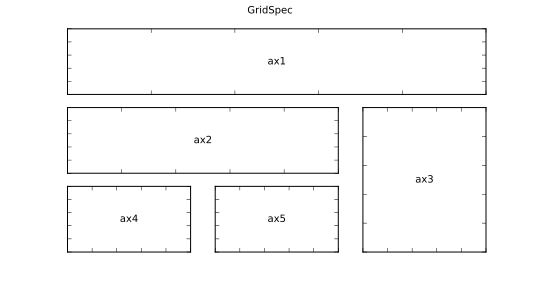

In [2]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize = (7.5,4.0))

def make_ticklabels_invisible(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        for tl in ax.get_xticklabels() + ax.get_yticklabels():
            tl.set_visible(False)

gs = GridSpec(3, 3)
ax1 = plt.subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0,0), colspan=3))
ax2 = plt.subplot(gs[1,:-1])
ax3 = plt.subplot(gs[1:, -1])
ax4 = plt.subplot(gs[-1,0])
ax5 = plt.subplot(gs[-1,-2])

plt.suptitle("GridSpec")
make_ticklabels_invisible(plt.gcf())
plt.close('all')
fig.savefig('fiveax_gridspec.svg')
display(SVG('fiveax_gridspec.svg'))

To construct a similar plot in figurefirst, we would draw five boxes in an svg layout document like the one shown below. This layout document would specify the total dimensions of the figure (7.5 by 4.0 in) as well as the placement and aspect ratio of the axes. Also, rather than specifiy the labels progammatically in python we have included them on a separate layer in the svg document.

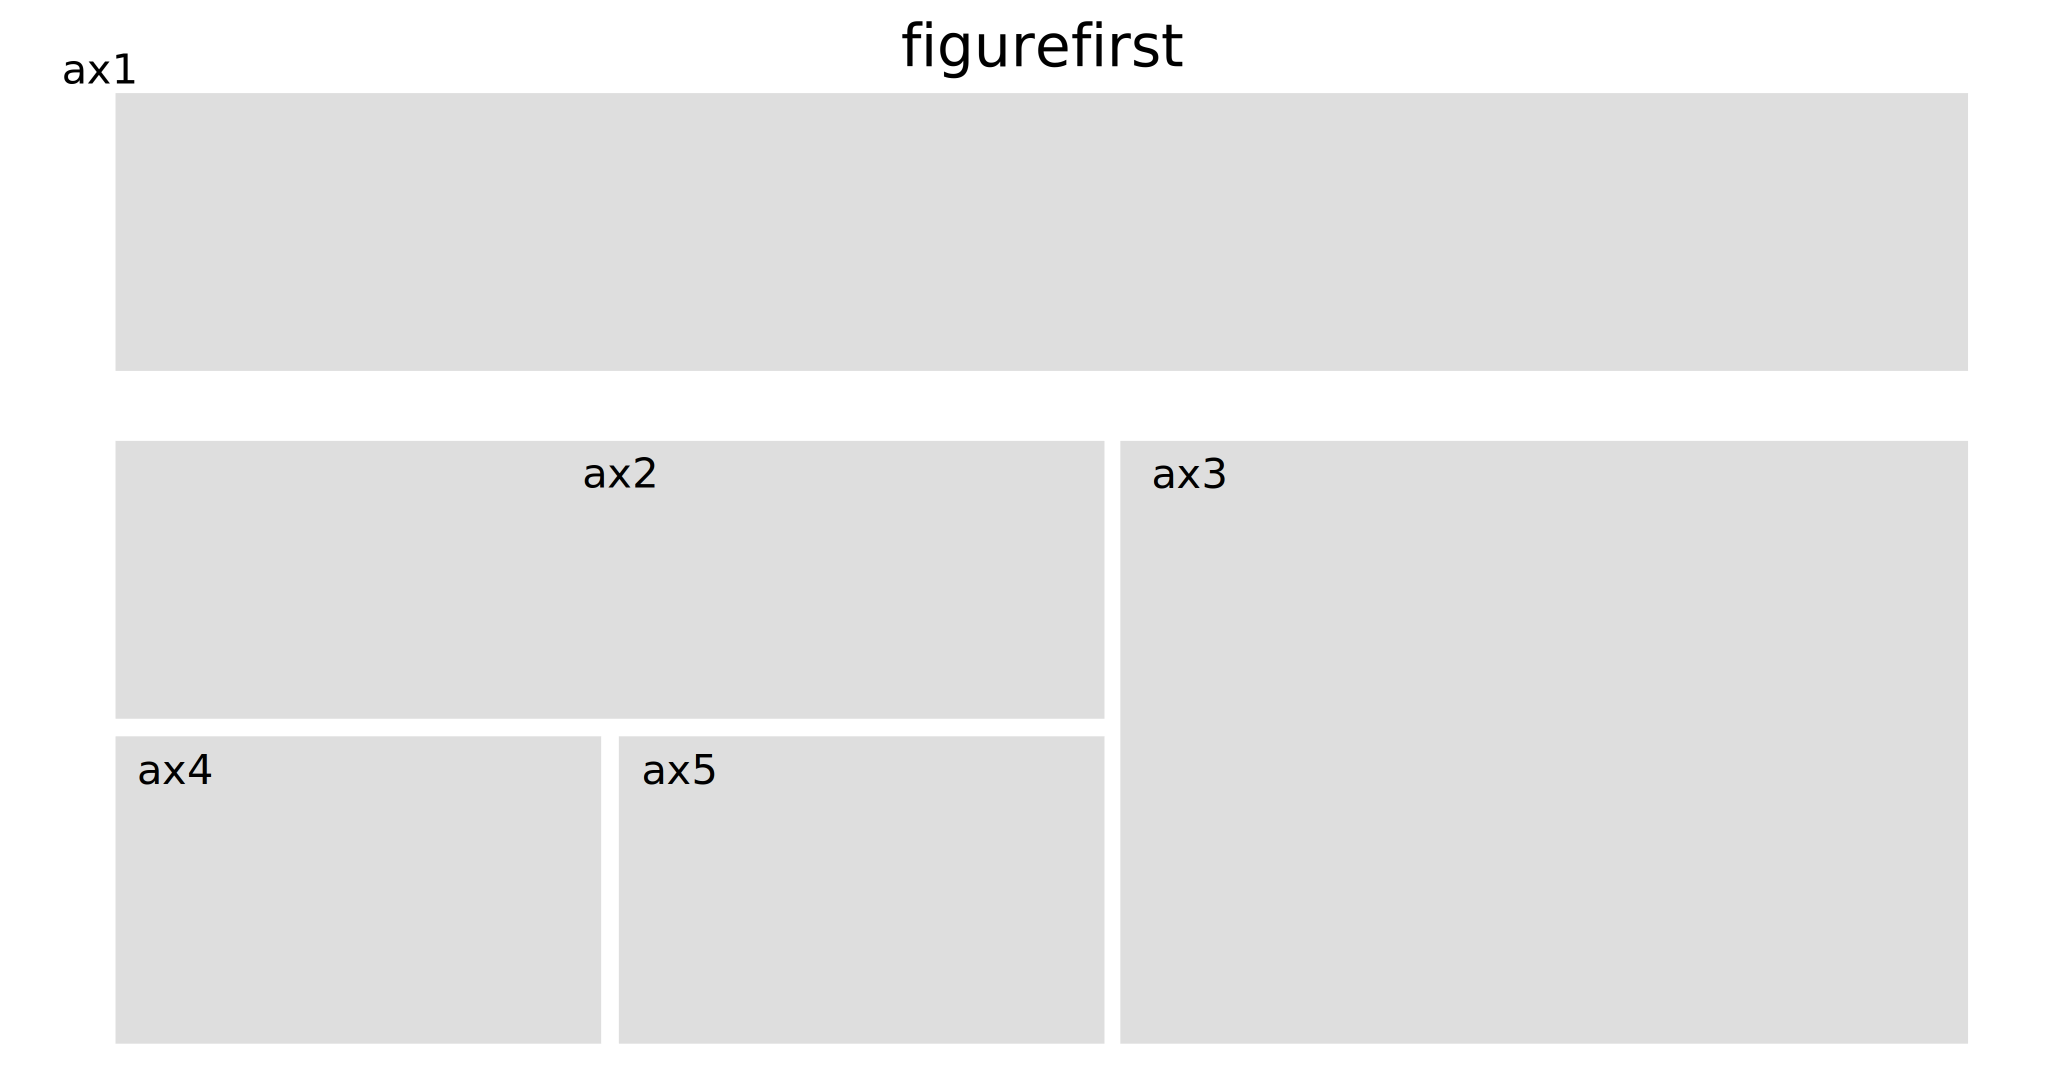

In [3]:
display(SVG('fiveax_layout.svg'))

Note that this is a somewhat special .svg file such that the each of these grey boxes has been tagged with some xml  that indicates its importance to figurefirst, and gives each box a name that will become available in python. We will explain details of this tagging procedure below, however, we have provided a number of inkscape extensions to streamline the process. You will probably also notice that this layout is a bit different than the output of GridSpec; ax2-3 are visually offset from ax1 and the label placement is less-ridged. We have done this intentionally to illustrate an advantage of using a layout. Those with experience using vector graphics packages such as Inkscape will know that graphic elements can be positioned very precisely and the more regular structure produced by GridSpec is easily achieved within the context of a layout. The reverse however -- specifying the less regular placement generated by this layout using just python -- would be a bit more difficult.

Now to use this layout to make figures, we pass the name of the layout file to the ```FigureLayout``` constructor and call the ```make_mplfigures()``` method.

targetlayer mpl_layer not found inserting into mpltarget


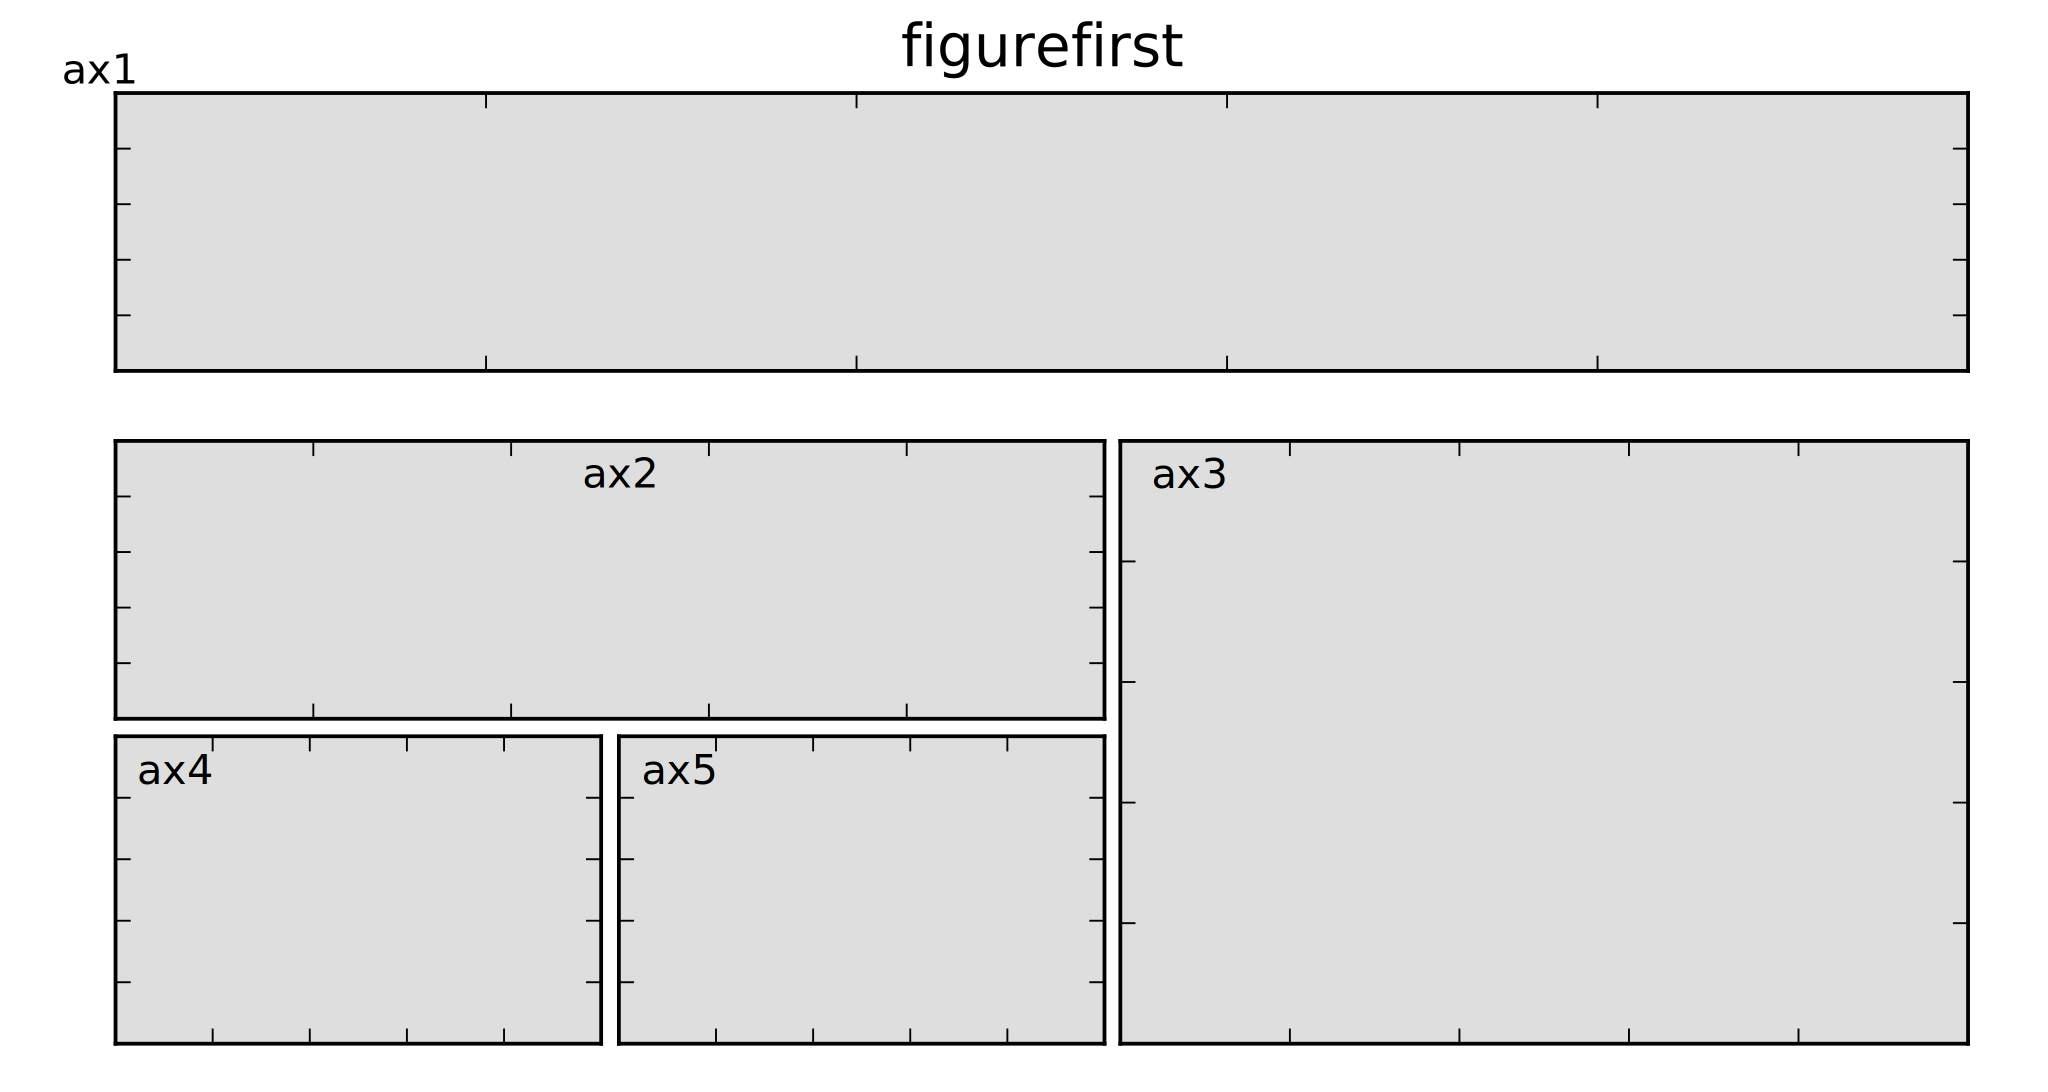

In [4]:
layout = fifi.FigureLayout('fiveax_layout.svg')
layout.make_mplfigures()
[kill_labels(ax) for ax in layout.axes.values()]
layout.insert_figures()
layout.write_svg('fiveax_test_output.svg')
plt.close('all')
display(SVG('fiveax_test_output.svg'))

After the call to layout.make_mplfigures() we then have access to a dictionary of matplotlib figures in the axes attribute of the layout object. The keys in this dictionary come from the data we passed in via xml. We can then treat these objects like any other maplotlib axis, by plotting to them for example. Here we simply pass them to the ```kill_labels()``` function to remove the tick labels. 

When we are done plotting and manipulating the axes objects, we then send the results back into a target svg layer, merging the graphical elements in the layout with those produced by matplotlib. Since the results of matplotlib get sent into a separate layer, we can remove or hide unwanted elements from the layout, for instance those ugly grey boxes: 

--- note that we can iterate now.
--- add set layer visibility option.

# Introduction to SVG

# Tagging axes

# Passing axis methods

You can decorate the ```svg <figurefirsrt:axis>``` tag with ```mpl.axis``` methods. For example to call:

```python
ax.axhspan(100,200,zorder=10,color ='r',alpha = 0.3)
``` 

on the axis named ```frequency.22H05.start``` use the following tag:

```xml
<figurefirst:axis
     figurefirst:name="frequency.22H05.start"
     figurefirst:axhspan="100,200,zorder=10,color='r',alpha=.3"/> ```
     
The layout.apply_mpl_methods function will then apply the methods passing the value of the svg atribute as arguments to the ```mpl.axis``` method.

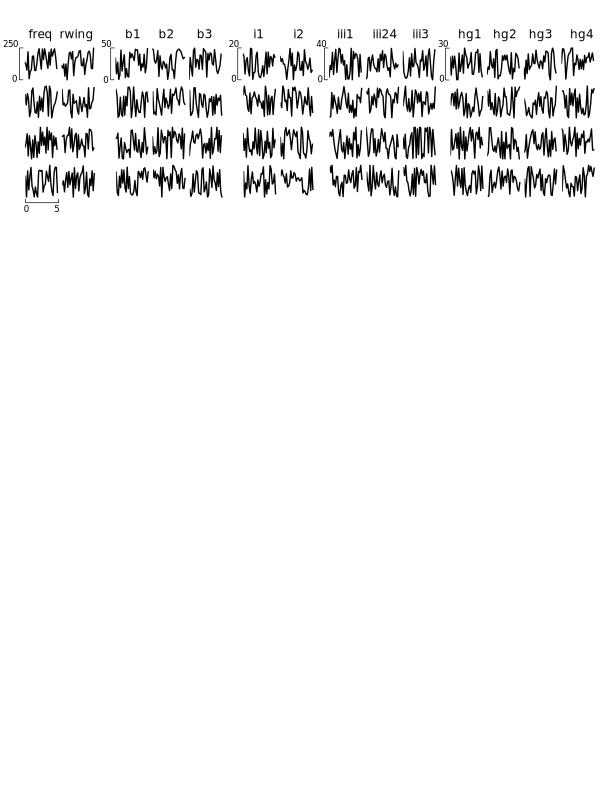

In [144]:
#Passing axis methods
import numpy as np
layout = fifi.FigureLayout('axis_methods_layout.svg')
layout.make_mplfigures()
layout.fig.set_facecolor('None')
for mplax in layout.axes.values():
    ax = mplax['axis']
    ax.plot(np.arange(30),np.random.rand(30),color = 'k')
    fifi.mpl_functions.adjust_spines(ax,'none', 
                  spine_locations={}, 
                  smart_bounds=True, 
                  xticks=None, 
                  yticks=None, 
                  linewidth=1)
    ax.patch.set_facecolor('None')
layout.apply_mpl_methods()
layout.insert_figures('mpl_panel_a')
layout.write_svg('axis_methods_test_output.svg')
plb.close('all')
display(SVG('axis_methods_test_output.svg'))

# Using groups

It is also possible to add figurefirst attributes to groups. Providing the figurefirsrt:groupname = "mygroup" attribute will cause the enclosed figurefirst:axes elements to be added to the layout.axes_groups dictionary keyed by groupname, and then axis name. For instance, if the follwing group exists in svg:

```xml
  <g
       style="display:inline"
       transform="matrix(0.88667385,0,0,0.84804291,-1.1136586,117.0766)"
       id="g3965-1"
       figurefirst:groupname="oval">
       <rect
         y="34.986671"
         x="70.899071"
         height="42.857143"
         width="594.55908"
         id="rect2985-3-0"
         style="fill:#008000">
        <figurefirst:axis
           figurefirst:name="circadian" />
        </rect>
   </g>
```
python will expose the axis in the dictionary axis groups attached to the layout keyed by group name and axis name.
```python
layout.axes_groups['oval']['circadian']['axis']
``` 
All axes that are not included in a group  will be collected into the field
```python
layout.axes_groups['none']
```

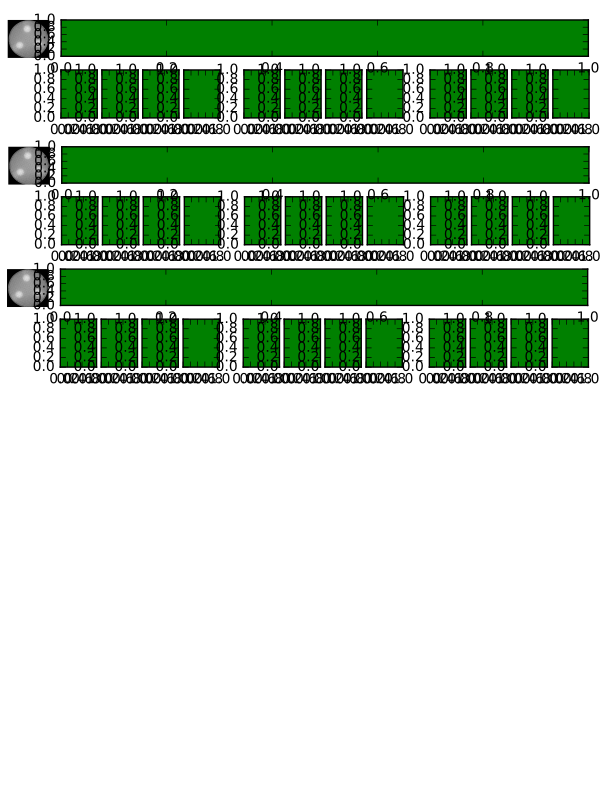

In [139]:
#Group axes example
layout = fifi.FigureLayout('group_axes_layout.svg')
layout.make_mplfigures()
layout.insert_figures()
layout.write_svg('group_axes_test_output.svg')
plb.close('all')
display(SVG('group_axes_test_output.svg'))

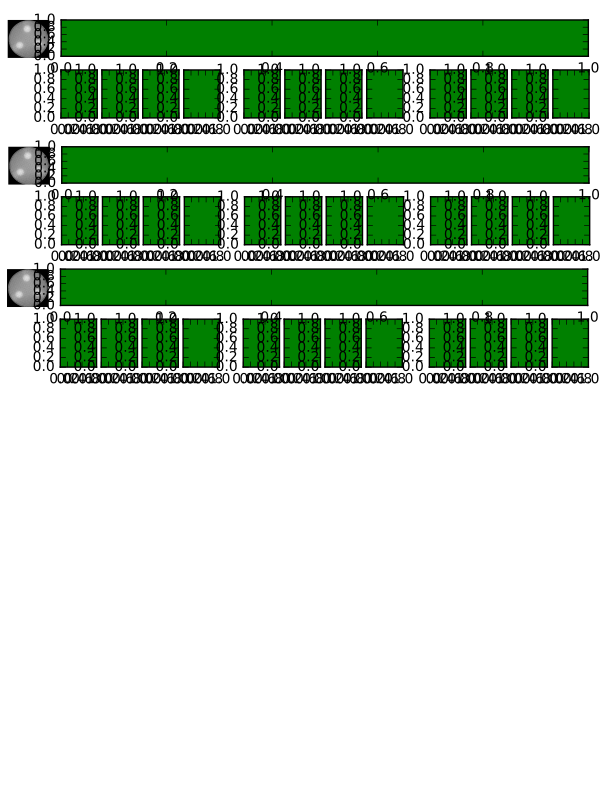

In [140]:
#Groups and figures example
layout = fifi.FigureLayout('multi_figures_layout.svg')
mplfig = layout.make_mplfigures()
layout.append_figure_to_layer(layout.figures.values()[0],'mpl_layer_2')
layout.append_figure_to_layer(layout.figures.values()[1],'mpl_layer_3')
layout.append_figure_to_layer(layout.figures.values()[2],'mpl_layer_4')
layout.write_svg('multi_fig_test_output.svg')
plb.close('all')
display(SVG('multi_fig_test_output.svg'))

# Using pathspec and patchspec

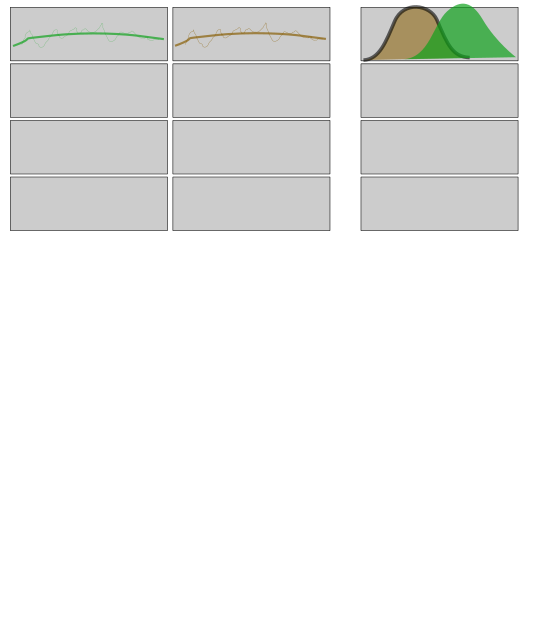

In [155]:
#this is the layout file
display(SVG('pathspec_layout.svg'))

In [156]:
# we collect some data
groupA_mean = 1.5
groupA_sigma = 1.0
groupB_mean = 0.3
groupB_sigma = 0.6
c1_effect = 0.3
c2_effect = 2.0
c3_effect = 0.0
c4_effect = 0.0

data = dict()

N = 500
T = 1.
Delta = T/N
for group_name,group_mean,group_sigma in zip(['A','B'],
                                             [groupA_mean,groupB_mean],
                                             [groupA_sigma,groupB_sigma]):
    data[group_name] = dict()
    for cond_name,cond_effect in zip(['cond_1','cond_2','cond_3','cond_4'],
                                     [c1_effect,c2_effect,c3_effect,c4_effect]):
        data[group_name][cond_name] = list()
        for trial in range(10):
            W = np.zeros(N+1)
            t = np.linspace(0, T, N+1);
            W[:N+1] = cond_effect + group_mean + np.cumsum(np.sqrt(Delta) *
                                                            np.random.standard_normal(N+1) *
                                                            group_sigma)
            t = np.linspace(0, T, N+1);
            data[group_name][cond_name].append(W)

In [157]:
#to remove spines
def kill_spines(ax):
    return fifi.mpl_functions.adjust_spines(ax,'none', 
                  spine_locations={}, 
                  smart_bounds=True, 
                  xticks=None, 
                  yticks=None, 
                  linewidth=1)

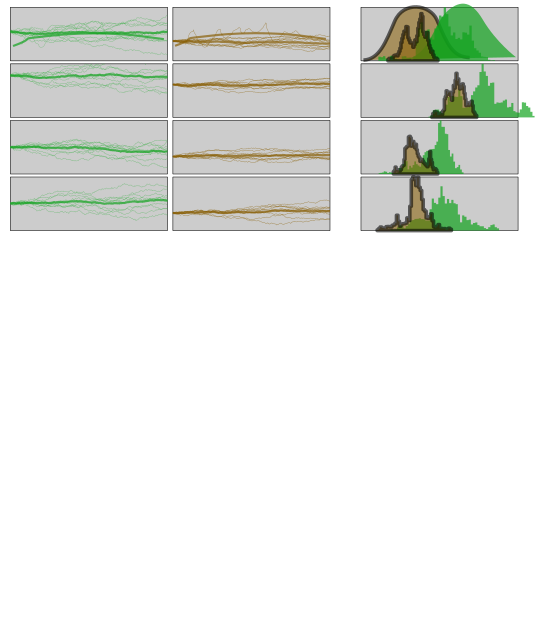

In [162]:
#to remove spines
def kill_spines(ax):
    return fifi.mpl_functions.adjust_spines(ax,'none', 
                  spine_locations={}, 
                  smart_bounds=True, 
                  xticks=None, 
                  yticks=None, 
                  linewidth=1)

## create a layout
layout = fifi.FigureLayout('pathspec_layout.svg')
## make the mpl figure objects
mplfig = layout.make_mplfigures()
## load the line and path specs to get plotting colors and effects
layout.load_pathspecs()
## iterate through what you want to plot and find the needed data,
## not the other way around..
for group_name,group in layout.axes_groups.items():
    if not(group_name == 'summary'):
        for cond_name,cond_ax in group.items():
            group_letter = group_name.split('group')[1]
            kwargs = layout.pathspecs['trial_%s'%group_letter].mplkwargs()
            cond_ax['axis'].plot(np.array(data[group_letter][cond_name]).T,**kwargs)
            
            kill_spines(cond_ax['axis'])
            kwargs = layout.pathspecs['mean_%s'%group_letter].mplkwargs()
            cond_ax['axis'].plot(np.mean(np.array(data[group_letter][cond_name]).T,axis = 1)
                                 ,**kwargs)
            cond_ax['axis'].set_ybound(-2,5)
    else:
        group_letter = 'A'
        kwargs = layout.pathspecs['hist%s'%group_letter].mplkwargs()
        for cond_name,cond_ax in group.items():
            cond_ax['axis'].hist(np.array(data[group_letter][cond_name]).ravel(),
                                 bins = 50,histtype = 'stepfilled',clip_on = False,**kwargs)
            cond_ax['axis'].set_xbound(-2,5)
            kill_spines(cond_ax['axis'])
        group_letter = 'B'
        kwargs = layout.pathspecs['hist%s'%group_letter].mplkwargs()
        for cond_name,cond_ax in group.items():
            cond_ax['axis'].hist(np.array(data[group_letter][cond_name]).ravel(),
                                 bins =50,histtype = 'stepfilled',clip_on = False,**kwargs)
            cond_ax['axis'].set_xbound(-2,5)
            kill_spines(cond_ax['axis'])

## insert the figures into the layout and save
layout.insert_figures()
layout.write_svg('pathspec_test_output.svg')
plb.close('all')
display(SVG('pathspec_test_output.svg'))

# Complete example